In [2]:
import h5py
from matplotlib import colors
import matplotlib.pyplot as plt
from neural_analysis.matIO import loadmat
import numpy as np
import pandas as pd
import ssm
from ssm.util import find_permutation
import sys
from tqdm.auto import tqdm

sys.path.append('../..')
from nld_utils import simulate_lorenz
from up_down import get_up_down
from utils import get_sample_interval, load, save

# Neural Data

## Load Data

In [3]:
filename = '../../__data__/Mary-Anesthesia-20160809-01.mat'
# filename = r'/Volumes/common/datasets/anesthesia/mat/propofolPuffTone/Mary-Anesthesia-20160809-01.mat'
# filename = r'/Volumes/common/datasets/anesthesia/mat/propofolWakeUp/Mary-Anesthesia-20170203-02.mat'
f = h5py.File(filename, 'r')
electrode_info, session_info, spike_times, unit_info = loadmat(filename, variables=['electrodeInfo', 'sessionInfo', 'spikeTimes', 'unitInfo'], verbose=False)
spike_times = spike_times[0]
dt = get_sample_interval(f, units='s')
lfp = f['lfp']
T = lfp.shape[1]

## Up and Down States

In [3]:
area_spike_dict = {}
for area in session_info['areas']:
    print(area)
    unit_inds = np.where(unit_info['area'] == area)[0]
    area_spike_dict[area] = np.zeros((len(unit_inds), T))
    for i, ind in enumerate(unit_inds):
        unit_spike_times = spike_times[ind][0, :]
        for t in unit_spike_times:
            area_spike_dict[area][i, int(t/dt)] = 1

vlPFC
FEF
CPB
7b


In [4]:
up_down_dict = get_up_down(area_spike_dict)

# Big Run

In [100]:
# Set the parameters of the SLDS
n_disc_states = 2      # number of discrete states
latent_dim = 2 # number of latent dimensions
emissions_dim = lfp.shape[0]      # number of observed dimensions

# areas = ['vlPFC', 'FEF', 'CPB', '7b']
areas = np.unique(electrode_info['area'])
unit_indices = np.arange(lfp.shape[0])[pd.Series(electrode_info['area']).isin(areas)]
stride = 5 # s
duration = 10 # s

In [ ]:
start_times = np.arange(0, lfp.shape[1]*dt - duration + 0.1, stride).astype(np.int)


results = []
for start_time in tqdm(start_times):
    # ------------------
    # get signal
    # ------------------
    start_step = int(start_time/dt)
    length = int(duration/dt)
    data = f['lfp'][unit_indices, start_step:start_step + length].T
    var_names = [f"unit_{unit_num} {electrode_info['area'][unit_num]}" for unit_num in unit_indices]
    time_vals = np.arange(start_time, start_time+duration, dt)
    
    # Create the model and initialize its parameters
    slds = ssm.SLDS(emissions_dim, n_disc_states, latent_dim, emissions="gaussian_orthog", verbose=False)

    # Fit the model using Laplace-EM with a structured variational posterior
    q_lem_elbos, q_lem = slds.fit(data, method="laplace_em",
                                   variational_posterior="structured_meanfield",
                                   num_iters=10, alpha=0.0, verbose=False)
    
    criticality_inds = np.zeros((n_disc_states, latent_dim))
    eigs = np.zeros((n_disc_states, latent_dim), dtype='complex')
    for i in range(n_disc_states):
        eigs[i] = np.linalg.eig(slds.dynamics._As[i])[0]
        criticality_inds[i] = np.abs(eigs[i])
        criticality_inds[i].sort()
        criticality_inds[i] = criticality_inds[i][::-1]
    
    q_lem_x = q_lem.mean_continuous_states[0]
    preds = slds.smooth(q_lem_x, data)
    mse = ((preds - data)**2).mean()
    
    disc_states = slds.most_likely_states(q_lem_x, data)
    
    
    results.append(dict(
        start_time=start_time,
        duration=duration,
        start_step=start_step,
        length=length,
        unit_indices=unit_indices,
        areas=areas,
        slds=slds,
        q_lem_elbos=q_lem_elbos,
        q_lem=q_lem,
        eigs=eigs,
        criticality_inds=criticality_inds,
        mse=mse,
        disc_states=disc_states
    ))

In [71]:
save(results, "../../__data__/slds/slds_biiiig_run_full_brain")

array([1875.35996667, 1875.36096667, 1875.36196667, ..., 3675.35796662,
       3675.35896662, 3675.35996662])

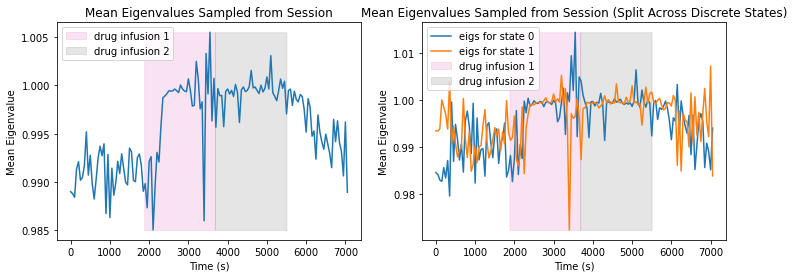

In [77]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
mean_eigs = np.array([results[i]['criticality_inds'].mean() for i in range(len(results))])
plt.plot(start_times, mean_eigs)
plt.fill_between(np.arange(f['sessionInfo']['drugStart'][0], f['sessionInfo']['drugEnd'][0], dt), 
                            mean_eigs.min(), mean_eigs.max(), color='C6', alpha=0.2, label='drug infusion 1')
plt.fill_between(np.arange(f['sessionInfo']['drugStart'][1], f['sessionInfo']['drugEnd'][1], dt), 
                            mean_eigs.min(), mean_eigs.max(), color='C7', alpha=0.2, label='drug infusion 2')
plt.xlabel('Time (s)')
plt.ylabel('Mean Eigenvalue')
plt.title("Mean Eigenvalues Sampled from Session")
plt.legend()

plt.subplot(1, 2, 2)
mean_eigs = np.array([results[i]['criticality_inds'].mean(axis=1) for i in range(len(results))])
for i in range(n_disc_states):
    plt.plot(start_times, mean_eigs[:, i], label=f'eigs for state {i}')
plt.xlabel('Time (s)')
plt.ylabel('Mean Eigenvalue')
plt.title("Mean Eigenvalues Sampled from Session (Split Across Discrete States)")
plt.fill_between(np.arange(f['sessionInfo']['drugStart'][0], f['sessionInfo']['drugEnd'][0], dt), 
                            mean_eigs.min(), mean_eigs.max(), color='C6', alpha=0.2, label='drug infusion 1')
plt.fill_between(np.arange(f['sessionInfo']['drugStart'][1], f['sessionInfo']['drugEnd'][1], dt), 
                            mean_eigs.min(), mean_eigs.max(), color='C7', alpha=0.2, label='drug infusion 2')
plt.legend()
plt.show()

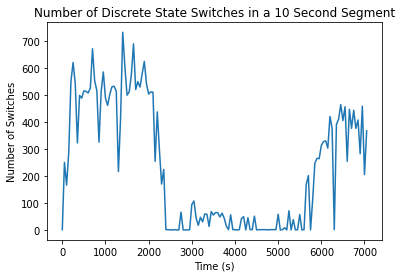

In [48]:
num_switches = [np.sum(np.diff(results[i]['disc_states']) != 0) for i in range(len(results))]
plt.plot(start_times, num_switches)
plt.title(f"Number of Discrete State Switches in a {duration} Second Segment")
plt.xlabel('Time (s)')
plt.ylabel('Number of Switches')
plt.show()

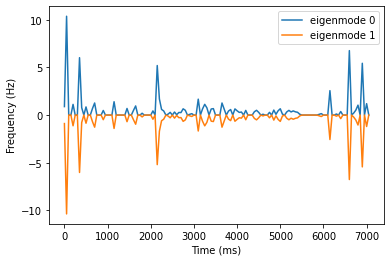

In [99]:
def to_freqs(x):
    freqs = np.zeros(x.shape)
    for n in range(x.shape[0]):
        for i in range(x.shape[1]):
            freqs[n, i] = np.angle(x[n, i])/(2*np.pi*dt)
    return freqs
freqs = [to_freqs(results[i]['eigs']) for i in range(len(results))]
for i in range(results[i]['eigs'].shape[1]):
    plt.plot(start_times, [freqs[j][0, i] for j in range(len(freqs))],  label=f'eigenmode {i}')
plt.xlabel('Time (ms)')
plt.ylabel('Frequency (Hz)')
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
mean_eigs = np.array([np.imag(results[i]['full_eigs']) for i in range(len(results))])
plt.scatter(start_times, mean_eigs)
plt.xlabel('Time (s)')
plt.ylabel('Mean Eigenvalue')
plt.title("Mean Eigenvalues Sampled from Session")

plt.subplot(1, 2, 2)
mean_eigs = np.array([results[i]['eigs'].mean(axis=1) for i in range(len(results))])
for i in range(n_disc_states):
    plt.scatter(start_times, mean_eigs[:, i], label=f'eigs for state {i}')
plt.xlabel('Time (s)')
plt.ylabel('Mean Eigenvalue')
plt.title("Mean Eigenvalues Sampled from Session (Split Across Discrete States)")
plt.legend()
plt.show()

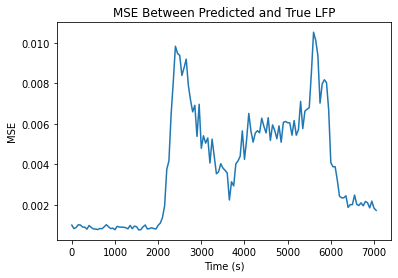

In [57]:
mse = np.array([results[i]['mse'] for i in range(len(results))])
plt.plot(start_times, mse)
plt.xlabel('Time (s)')
plt.ylabel('MSE')
plt.title("MSE Between Predicted and True LFP")
plt.show()